In [1]:
#importing the necessary modules
import torch
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

import cv2
from skimage import io

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Exploration

In [2]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('Train .csv')
test_data = pd.read_csv('Test .csv')
train_path = 'data/train/'
test_path = 'data/test/'

In [3]:
# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']


In [4]:
train.head()

,filepath,LABEL,ID
0,data/train/VTYNBFTO.png,Positive,VTYNBFTO
1,data/train/GVVXXDOZ.png,Normal,GVVXXDOZ
2,data/train/PMRSQLXN.png,Normal,PMRSQLXN
3,data/train/JXISWDUU.png,Positive,JXISWDUU
4,data/train/JVWMAACC.png,Positive,JVWMAACC


In [5]:
test.head()

,filepath,ID
0,data/test/GTWSHFYQ.png,GTWSHFYQ
1,data/test/QTFSSMGD.png,QTFSSMGD
2,data/test/TBLBHSYT.png,TBLBHSYT
3,data/test/ZKETEOFG.png,ZKETEOFG
4,data/test/GKTPBGZP.png,GKTPBGZP


In [6]:
print("Train data shape is ",train.shape)
print("Test data  shape is ",test.shape)

Train data shape is  (718, 3)
Test data  shape is  (82, 2)


/home/gerald/anaconda3/envs/tb_zindi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


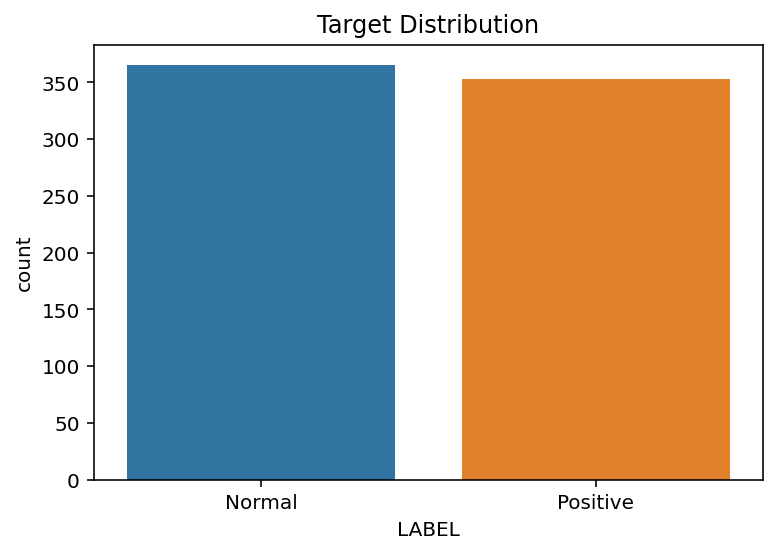

In [7]:
## EDA & PREPROCESSING
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

### Observation
* Our target column seems to be well balanced in the data set

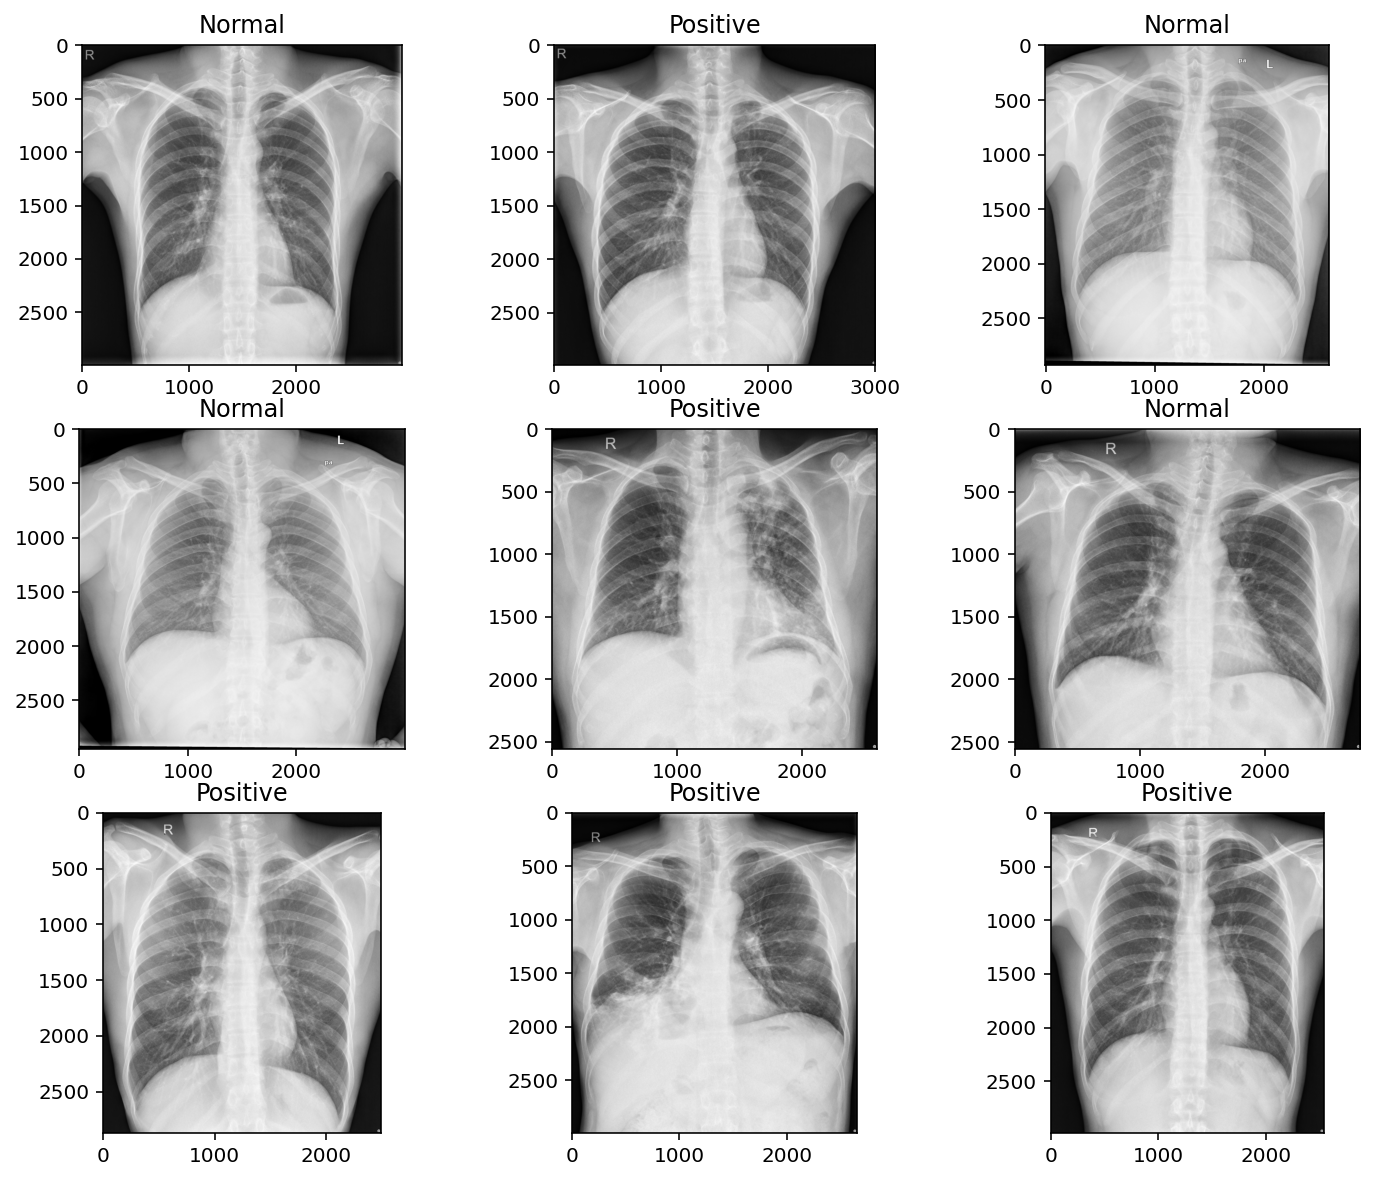

In [8]:
#Visualizing random images

#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [9]:
#creating a tranform object to convert our image to tensors
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

In [10]:
class ImageData(Dataset):
    def __init__(self,data_df,images_dir,transform = None):
        self.annotations = data_df
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.images_dir,self.annotations.iloc[index,2]+".png")
        image = io.imread(img_path)
        img_label = self.annotations.iloc[index,1]
        #img_dict = {'image':image,'img_label':img_label}
        
        
        if self.transform:
            image = self.transform(image)
        
        return image,img_label

In [31]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [32]:
#defining our data paths
train_data = ImageData(data_df= train,images_dir='data/train',transform = data_transforms['train'])
validation_data = ImageData(data_df= train,images_dir='data/train',transform = data_transforms['val'])

In [44]:
from PIL import Image
#visualizing our sample data
fig = plt.figure()

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample[0].shape, sample[1])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(sample[1])
    ax.axis('off')
    image = cv2.imread(sample[0])
    plt.imshow(image)
    
    if i == 3:
        
        plt.show()
        break

TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>

<Figure size 432x288 with 0 Axes>

### Observation
* Our images have different shape
* We have to standardize them

In [34]:
#function to create training and validation datasets
def split_indices(len_data,val_pct):
    #creating a list of indices of the data
    dataset_indices = list(range(len_data))
    #shuffling the list of indices
    np.random.shuffle(dataset_indices)
    #creating the split index
    val_split_index = int(np.floor(val_pct * len_data))
    return dataset_indices[val_split_index:],dataset_indices[:val_split_index]

In [35]:
train_idx,val_idx = split_indices(len(train_data),0.2)

In [36]:
#creating the samplers
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(val_idx)

In [37]:
#Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 1

In [38]:
train_loader = DataLoader(dataset=train_data,shuffle=False,batch_size = batch_size,sampler=train_sampler)
val_loader = DataLoader(dataset=validation_data,shuffle= False,batch_size = batch_size,sampler=validation_sampler)

In [39]:
def img_classifier(num_input_features,hidden_layers,num_output_features):
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0',nn.Linear(num_input_features,102))
    else:
        layer_sizes = zip(hidden_layers[:-1],hidden_layers[1:])
        classifier.add_module('fc0',nn.Linear(num_input_features,hidden_layers[0]))
        classifier.add_module('relu0',nn.ReLU())
        classifier.add_module('drop0',nn.Dropout(p=0.5))
        
        for i,(h1,h2) in enumerate(layer_sizes):
            classifier.add_module()

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(train_loader, train_data)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(val_loader, train_data)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')

In [40]:
#model
model = torchvision.models.googlenet(pretrained = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [41]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [42]:
#training our network
for epoch in range(num_epochs):
    losses = []
    
    for batch_idx,(inputs,targets) in enumerate(train_loader):
        # get data to cuda if possible
        inputs = inputs.to(device = device)
        targets = targets.to(device = device)
        
        #forward
        scores = model(inputs)
        loss = criterion(scores,targets)
        
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #perform gradient descent
        optimizer.step()
        
    print(f'Cost at each epoch{epoch} is {sum(losses)/len(losses)}')

TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>

In [ ]:
#getting our train and test data and converting it to tensors
train_data = datasets.ImageFolder('train/',transform = train_transform)
#test_data = torchvision.datasets.ImageFolder('test/',transform = test_transform)
valid_data = torchvision.datasets.ImageFolder('train/',transform = test_transform)

In [ ]:
#Splitting the training data into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))

#shuffling the data
np.random.shuffle(indices)

#using the SubsetRandomSampler for the split
from torch.utils.data.sampler import SubsetRandomSampler

#our validation size is 20% of training data
validation_size = 0.2
split = int(np.floor(validation_size * num_train))
train_split,val_split = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_split)
test_sampler = SubsetRandomSampler(val_split)
trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size = 32)
validationloader = torch.utils.data.DataLoader(valid_data,sampler=test_sampler,batch_size = 32)


In [ ]:
print(trainloader.dataset.classes)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

## Loading our dataset